# Assignment 2 - Image Captioning

This notebook contains the required task for the second assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of image captioning : -from loading and inspecting the dataset; -to implementing, training and evaluating an Encoder-Decoder + Attention based architecture. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- From the provided Flickr8k dataset, split it into train, val and test sets;
- Use the train set to train an Image Captioning model, the val set for validation of the model and hyper-parameters, and the test set to evaluate the final trained model;
- For this assignment, we will give importance to the performance of your model, meaning that, we will evaluate if your model is overfitted or underfitted. For that, please include visualizations (print and plot) loss values for the split sets, as well as the metric results;
- For the metric, while we do not require high performance, we still expect better than random guessing results;
- For the comparison, you are free to choose any pre-trained model;
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is November 29th 11:59 PM** (strict, no late submission);
- Feel free to add more code cells as needed. But don't put code into external Python files;
- Please add your name, **Neptun ID**, and task details below.

**Name:** Eliyas KIdanemariam Abraha 

**Neptun ID:** P6013D

## Task description

Your task is to train your own custom image captioning model and compare its performance with an existing (pre-trained) model. For that, first you need to load the provided Flickr8k dataset, split into train, val and test sets. Then, create your own architecture, which should follow an Encoder-Decoder + Attention sturcture. You can use pre-trained backbones (i.e. ResNet) for the encoder, but they have to be fine-tuned. We expect you to use an Attention layer, in order to visualize how the network learned (see more details on section 2 of the notebook).
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs. Please use BLEU score as the metric**. We expect you to **show visualizations (prints and plots)** of the **metrics, losses, and predictions**. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your architecture.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [ ]:
# Fix to work on colab
!pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 torchtext==0.17 --index-url https://download.pytorch.org/whl/cu121

In [5]:

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
#show the tensor image
import matplotlib.pyplot as plt



# 1. DATASET
For this assignment you will be using the [Flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) dataset, which contains captions/descriptions of different images.

### 1.1. Download dataset
The best way to download this dataset is through Kaggle.
First create a token, download it and upload it here. Follow these steps: https://www.kaggle.com/discussions/general/74235

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

### 1.2. Load dataset
In order to load the dataset, you need to create a pytorch Dataset class.
The class should return images and captions. Remember that the captions should be returned as tokens. Do not forget to include the SOS:start of sentence, EOS:end of sentence and UNK:unknown tokens. You may want to build a vocabulary class in order to save all the words in your dataset, because your model can only predict words in your vocabulary. You do not have to save every word in your vocabulary, it is common practice to save only those words that appear multiple times in your whole dataset. For example, save only words that appear at least 5 times in your whole dataset.

In [3]:
# ADD YOUR CODE HERE
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5): #generous hint
        
        self.root_dir = root_dir
        self.caption_dir = root_dir + captions_file
        self.img_dir = root_dir + 'Images'
        # read txt file
        self.df = pd.read_csv(self.caption_dir, sep=',')
        # print(self.df.head())
        #initialize vocabulary and build vocab
        self.transform = transform
        self.freq_threshold = freq_threshold
        self.vocab = self.build_vocab()
        
        self.vocab_len = len(self.vocab)
        self.vocab_to_index = {word: idx for idx, word in enumerate(self.vocab)}
        self.index_to_vocab = {idx: word for word, idx in self.vocab_to_index.items()}
        self.caption_vector = self.vectorize_caption()

    def build_vocab(self):
        word_freq = {}
        for idx in range(len(self.df)):
            caption = self.df.iloc[idx]['caption']
            words = caption.split(' ')
            for word in words:
                if word not in word_freq:
                    word_freq[word] = 1
                else:
                    word_freq[word] += 1
        vocab = [word for word in word_freq if word_freq[word] > self.freq_threshold]
        vocab = ['<PAD>','<SOS>', '<EOS>', '<UNK>'] + vocab

        return vocab
    
    def vectorize_caption(self):

        caption_vector = []
        for idx in range(len(self.df)):
            caption = self.df.iloc[idx]['caption']
            words = caption.split(' ')
            words = ['<SOS>'] + words + ['<EOS>']
            caption_vec = []
            for word in words:
                if word not in self.vocab:
                    caption_vec.append(self.vocab_to_index['<UNK>'])
                else:
                    caption_vec.append(self.vocab_to_index[word])
            
            caption_vector.append(caption_vec)

        return caption_vector

    

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['image']
        img = Image.open(os.path.join(self.img_dir, img_id)).convert("RGB")
        caption_vector = self.caption_vector[idx]
        if self.transform is not None:
            img = self.transform(img)

        # captions realted with this image 
        captions = self.df[self.df['image'] == img_id]['caption'].tolist()

        return img, torch.tensor(caption_vector) , captions #generous hint
    
root_dir = 'flickr8k/' 
# Define image transformations

image_transform = transforms.Compose([
    transforms.Resize((224,224)),                                 
    transforms.ToTensor(),      
    transforms.RandomHorizontalFlip(),                         
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

def unnormalize_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    return img

dataset = FlickrDataset(root_dir = root_dir, captions_file = 'captions.txt', transform = image_transform, freq_threshold = 5)

Example output from dataset class

Token: tensor([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12,  7, 13, 14, 15,  6, 16,  3, 17,
        18,  2])
Caption : ['<SOS>', 'A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


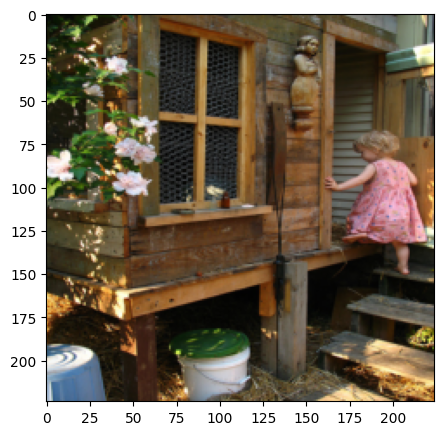

In [6]:

# Show some visualizations of the created
import matplotlib.pyplot as plt
img, caps ,_= dataset[0]

fig = plt.figure(figsize=(5,6))
plt.imshow( unnormalize_image(img))

# show_image(img,"Image")
print("Token:",caps)
# print("Sentence:")
print("Caption :" , [ dataset.index_to_vocab[token] for token in caps.tolist()])

Split your dataset into train, val and test sets

In [7]:
# split dataset into train , validation and test
from torch.utils.data import random_split
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

train_size = int(0.75 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])



Create a dataloader, in order to load the examples in batches. Remember that, a batch has different examples, and each example (caption) may have different sizes. Therefore, consider padding techniques for the captions. For the image, use transforms in the previous step, to ensure same format and size.  

In [8]:

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    images, captions , all_captions= zip(*batch)

    # Pad captions
    captions = [torch.tensor(caption) for caption in captions]
    padded_captions = pad_sequence(captions, batch_first=True, padding_value=0)
    # Stack images
    images = torch.stack(images, dim=0)
    return images, padded_captions , all_captions

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=16,shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

loader = iter(train_loader)
images, captions ,_ = next(loader)





/tmp/ipykernel_10050/515541939.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  captions = [torch.tensor(caption) for caption in captions]


#2. MODEL
For this assignment, you are required to create your own custom image captioning model and compare its performance with an existing pre-trained model.

In [9]:
#Make sure to use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 2.1. Custom Image Captioning model

Create an Encoder-Attention-Decoder architecture with the following details:
- the encoder should process the images, thus you can create a Convolutional based architecture or use already pre-trained models like ResNet. However, you must fine-tune the pretrained model. The encoder is responisble for extracting image features;
- the attention layer should be between the encoder and decoder. It uses the image features from the encoder in order to provide context (attention scores) to the decoder hidden layers. For simplicity use Linear layers as the attention architecture;
- the decoder should be a sequence based model (i.e. LSTM) in order to process and generate captions.

Extra:
- Extra points (counting toward the final grade) will be given to any student who implements either a Vision-based Transformer architecture or a Transformer only decoder for the decoder part.

#### Reference
Here is an example of something similar to what we want to create:
<img src="https://drive.google.com/thumbnail?id=1wdddaLit7iEyCcVy5bS505NiYzL6c-4x&sz=w1000">


In [10]:
import torch.nn as nn
import torchvision.models as models
class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(EncoderCNN, self).__init__()
        self.enc_image_size = encoded_image_size
        # Load the pretrained ResNet-50 model
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
       
    def forward(self, images):
        """
        Forward pass to extract image features
        """
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        
        return  features
    


In [11]:
# ADD YOUR CODE HERE
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim): #generous hint
        super(Attention, self).__init__()
        self.attention_dim = attention_dim
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        self.A = nn.Linear(attention_dim,1)
        
    def forward(self, features, hidden_state): #generous hint
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights 


In [ ]:
# ADD YOUR CODE HERE

class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            
            alpha,context = self.attention(features, h)
            lstm_input    = torch.cat((embeds[:, s], context), dim=1)
            h, c          = self.lstm_cell(lstm_input, (h, c))
            output        = self.fcn(self.drop(h))
            preds[:,s]    = output
            alphas[:,s]   = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        alphas = []
        #starting input
        word = torch.tensor(dataset.vocab_to_index['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)
        captions = []
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            #save the generated word
            captions.append(predicted_word_idx.item())
            #end if <EOS detected>
            if dataset.index_to_vocab[predicted_word_idx.item()] == "<EOS>":
                break
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [dataset.index_to_vocab[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

Combine the encoder - attention - decoder

In [13]:
# ADD YOUR CODE HERE
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
            
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

### 2.2. Training custom model

### Important: we recommend saving the model during training, so that you can resume training later in case of any Google Colab issue or limitation

In [14]:
#Hyperparams
embed_size=512
vocab_size = len(dataset.vocab)
attention_dim=512
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4
learning_rate = 0.0003

config = dict(
    lr = 0.00001, wt = 0.002,
    step = 10, gamma = 0.1,
    epochs = 30,
)



Pay attention to your choices. Define an optimizer, a loss function, the number of epochs and regularization techniques.
Be aware of overfitting and underfitting. Make sure the loss is decreasing over the epochs. Save the losses so that they can be visualized.

In [15]:
#init model
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size = len(dataset.vocab),
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim
).to(device)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab_to_index['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/elias/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/elias/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):

    checkpoint_dict = torch.load(filename , map_location=device)

    model.load_state_dict(checkpoint_dict['model'] )

    if optimizer is not None:
        print("Loading optimizer1")
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:   
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
  
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']

In [ ]:
# define trian step
from tqdm import tqdm
def train_step(model, train_loader,criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    for idx, (image, captions , _ ) in enumerate(iter(train_loader)):
        image,captions = image.to(device),captions.to(device)
        # Zero the gradients.
        optimizer.zero_grad()
        # Feed forward
        outputs,attentions = model(image, captions)
        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        # Backward pass.
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        # Update the parameters in the optimizer.
        optimizer.step()
        train_loss += loss.item()   

    return train_loss/len(train_loader)

def val_step(model, val_loader, criterion , device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for i, (image, captions, _) in enumerate(val_loader):
            image,captions = image.to(device),captions.to(device)
             # Feed forward
            outputs,attentions = model(image, captions)
            # Calculate the batch loss.
            targets = captions[:,1:]
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            val_loss += loss.item()

    return val_loss/len(val_loader)
    
    
# Train the model
def train_model( model,train_loader,val_loader,criterion,optimizer,scheduler , device,epochs = 10,
                 logging=False, checkpointing=False, resume_from_checkpoint=None):
    
    train_history = {
        "train_loss": [],
        "val_loss": [],
    }

    if resume_from_checkpoint:
        print('Resuming from checkpoint...')
        try:
          
            start, train_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
            print("start" , start)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except Exception as e:
            print('Error loading checkpoint! Training from scratch...\n' , e)

    if checkpointing:
        checkpoint_dir = 'checkpoints/image_caption/'
        print('Saving checkpoints in: '+checkpoint_dir)
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: '+checkpoint_dir)

    if logging:
        logs_dir = 'logs/image_caption/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir+'image_caption-xxx-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: '+log_file_path)
    
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model, train_loader,criterion , optimizer, device)
        val_loss  = val_step(model, val_loader,criterion,device)
        patience = 0
        # scheduler.step(val_class_loss + val_bbox_loss)
        scheduler.step()
        train_history["train_loss"].append(train_loss)
        train_history["val_loss"].append(val_loss)

        if logging:
            print('\nEpoch {}/{}'.format(epoch+1, epochs), file=log_file)
            print('-' * 10, file=log_file)
            print(f"Train C_Loss: {train_loss:.4f},:val_loss :{train_loss:.2f}", file=log_file)
        # print(f"Epoch: {epoch+1}/{epochs}, \n Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {val_loss:.4f}, Test Acc: {val_acc:.2f}%")
        print(f"Epoch: {epoch+1}/{epochs}, \n train_loss: {train_loss:.3f},:val_loss :{val_loss:.3f}\n")
         # save checkpoint
        if checkpointing and epoch % 10 == 0:
            checkpoint_filename = checkpoint_dir+'caption{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, train_history, epoch, checkpoint_filename)
        
        # apply early stopping if the validation loss does not decrease for 10 consecutive epochs
        if len(train_history["val_loss"])> 5 and val_loss >= train_history["val_loss"][-2]:
            patience += 1
            if patience == 5:
                print('Early stopping...')
                break      
        else:
            patience = 0



    return model , train_history


def plot_result(result):
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(result["train_loss"][""], label="train_loss")
    plt.plot(result["val_loss"], label="val_loss")
    plt.title("Loss")
    plt.legend()


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 25
print_every = 1000
scheduler = StepLR(optimizer, step_size=config['step'], gamma=config['gamma'])
# Train the model
epochs = 30
model, train_history = train_model(model, train_loader, val_loader, criterion , optimizer, 
                                   scheduler, device, epochs, logging=True, checkpointing=True)                       

plot_result(train_history)



Epoch 1/30
----------
Train C_Loss: 2.9006,:val_loss :2.90

Epoch 2/30
----------
Train C_Loss: 2.6846,:val_loss :2.68

Epoch 3/30
----------
Train C_Loss: 2.5470,:val_loss :2.55

Epoch 4/30
----------
Train C_Loss: 2.4431,:val_loss :2.44

Epoch 5/30
----------
Train C_Loss: 2.3572,:val_loss :2.36

Epoch 6/30
----------
Train C_Loss: 2.2810,:val_loss :2.28

Epoch 7/30
----------
Train C_Loss: 2.2137,:val_loss :2.21

Epoch 8/30
----------
Train C_Loss: 2.1526,:val_loss :2.15

Epoch 9/30
----------
Train C_Loss: 2.0973,:val_loss :2.10

Epoch 10/30
----------
Train C_Loss: 2.0448,:val_loss :2.04

Epoch 11/30
----------
Train C_Loss: 1.8946,:val_loss :1.89

Epoch 12/30
----------
Train C_Loss: 1.8659,:val_loss :1.87

Epoch 13/30
----------
Train C_Loss: 1.8515,:val_loss :1.85

Epoch 14/30
----------
Train C_Loss: 1.8413,:val_loss :1.84

Epoch 15/30
----------
Train C_Loss: 1.8286,:val_loss :1.83

Epoch 16/30
----------
Train C_Loss: 1.8198,:val_loss :1.82

Epoch 17/30
----------
Train C_L

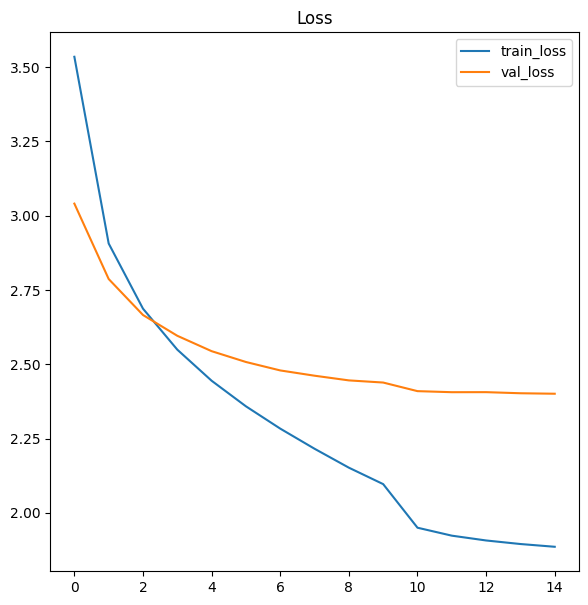

In [26]:
# ADD YOUR CODE HERE
resume_from_checkpoint= "checkpoints/image_caption/caption_finall031.pkl"
checkpoint_filename = "checkpoints/image_caption/"+'caption_finall{:03d}.pkl'.format(31)
def plot_result(result):
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(result["train_loss"][:15], label="train_loss")
    plt.plot(result["val_loss"][:15], label="val_loss")
    plt.title("Loss")
    plt.legend()

# read log file 
log_file_path = 'logs/image_caption/image_caption-xxx-log.txt'
with open(log_file_path, 'r') as file:
    print(file.read())

# save_checkpoint(scheduler, optimizer, model, train_history, 30, checkpoint_filename)
start, train_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
plot_result(train_history)


Visualize the attention weigths in order to understand how your model learned (**Failure to do this, will result in losing points**).
For that, use the 'context' variable returned by the Attention class to overlay them on the image.

/tmp/ipykernel_10050/515541939.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  captions = [torch.tensor(caption) for caption in captions]


Predicted: boy in a pool .
Actual: The children play in the pool .
Actual: Two children are playing in an outdoor swimming pool .
Actual: Two children playing in a swimming pool .
Actual: Two children play in the water of an above-ground pool .
Actual: Two little girls playing in the pool .


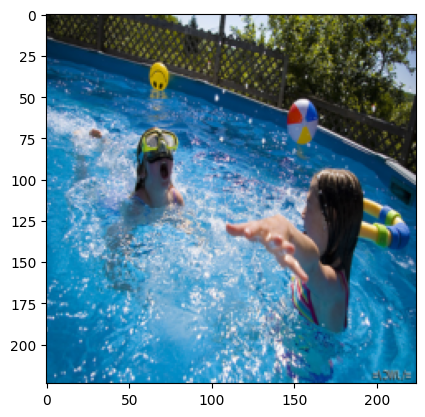

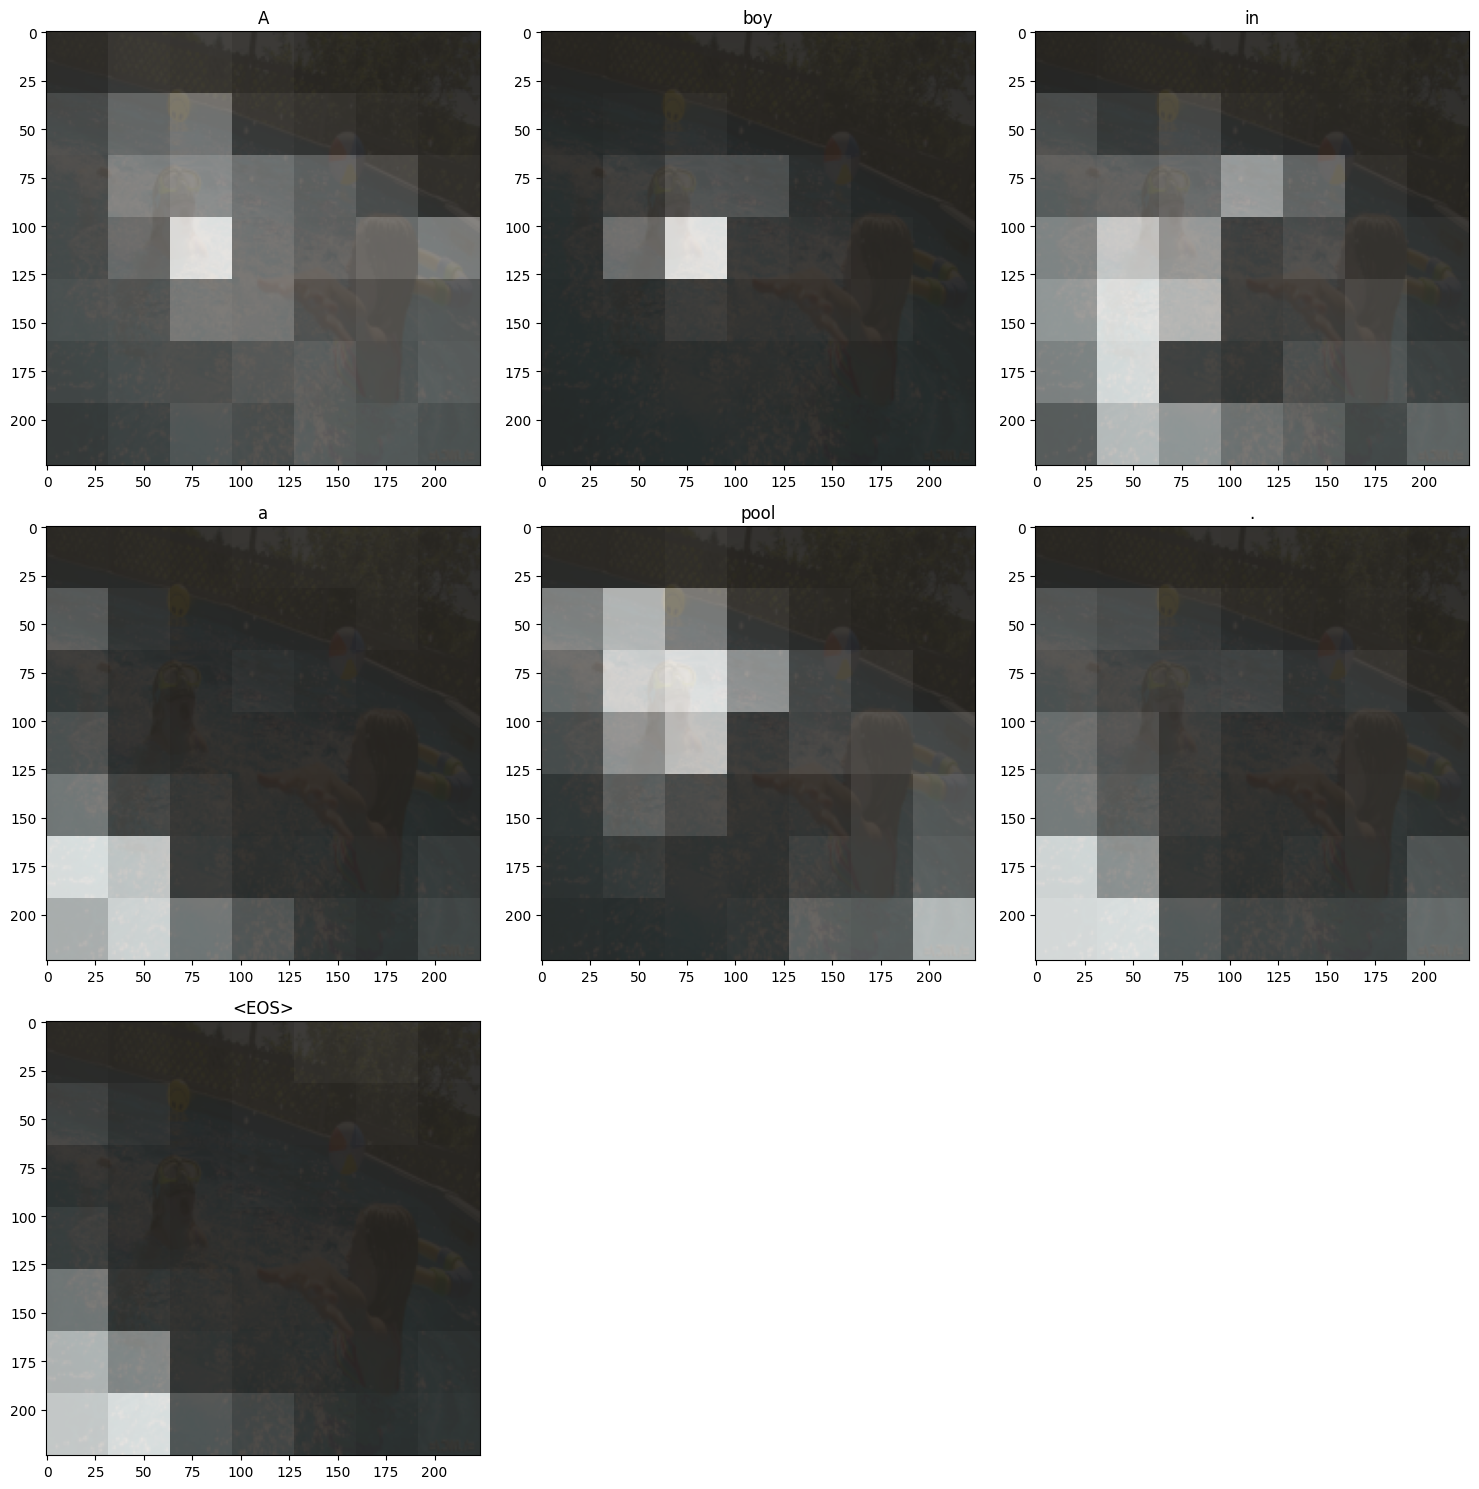

In [27]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    temp_image = unnormalize_image(img)
    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
    
    plt.tight_layout()
    plt.show()
#show any 1
dataiter = iter(test_loader)
images,caption,all_captions= next(dataiter)

caption = [dataset.index_to_vocab[token] for token in caption[0].tolist()]
img  = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

img = unnormalize_image(img1)
index_EOS = caption.index('<EOS>')

print("Predicted:",' '.join(caps[1:-1]))
for cap in all_captions[0]:
    print("Actual:",cap)


plt.imshow(img)
plot_attention(img1, caps, alphas)

/tmp/ipykernel_10050/515541939.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  captions = [torch.tensor(caption) for caption in captions]


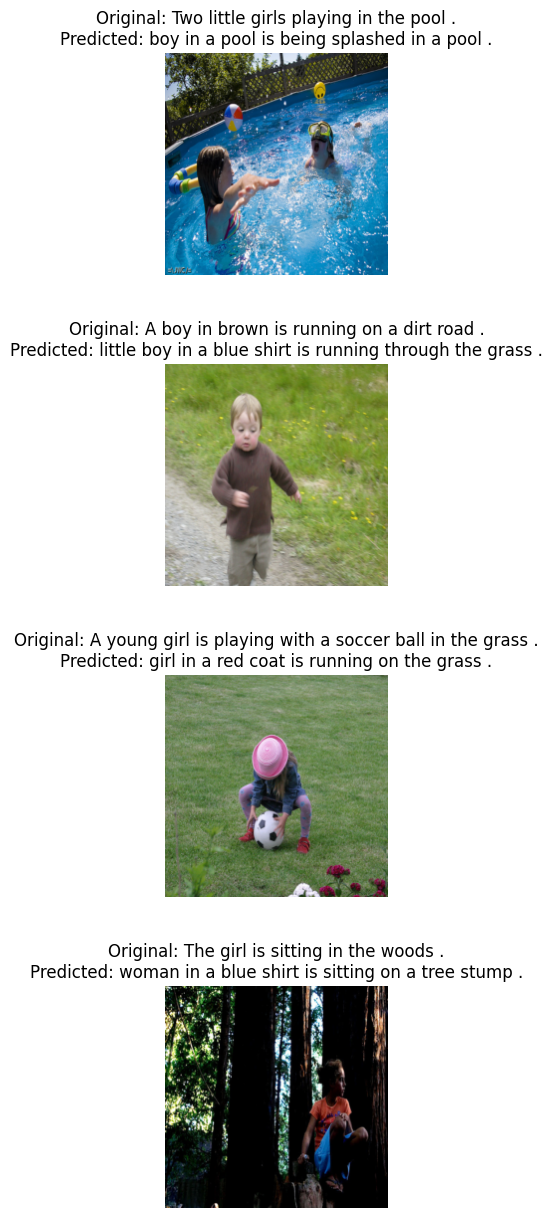

In [28]:
dataiter = iter(test_loader)
images,captions,_= next(dataiter)
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(15,15))

index = 0
for i , axes in enumerate(ax.flatten()):
    img = images[i].detach().clone()
    caps,alphas = get_caps_from(img.unsqueeze(0))
    img = unnormalize_image(img)
    caption = [dataset.index_to_vocab[token] for token in captions[i].tolist()]
    index_EOS = caption.index('<EOS>')
    predicted_caption = ' '.join(caps[1:-1])
    original_caption = ' '.join(caption[1:index_EOS])
    axes.set_title(f"Original: {original_caption}\nPredicted: {predicted_caption}")
    axes.imshow(img)
    axes.axis('off')
# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust these values as needed
plt.show()

### 2.3. Evaluation on test set

Evaluate your trained model on the test set. Use the BLEU score as your metric: torchtext.data.metrics.bleu_score(...)

You may try **BLEU-1, 2** and **3**.

In [29]:
# ADD YOUR CODE HERE
from torchtext.data.metrics import bleu_score
def evaluate_model(model, dataloader, vocab, device):
    model.eval()
    references = []
    hypotheses = []
    with torch.no_grad():
        for images, captions , all_captions in dataloader:
            images = images.to(device)
            captions = captions.to(device)
            captions = captions.cpu().detach().numpy()
            # print("Cap" , captions)  
            # Convert predictions and references to lists of tokens
            for i in range(len(captions)):
                img = images[i].detach().clone()
                img = img.unsqueeze(0)
                all_cations = all_captions[i]

                features = model.encoder(img.to(device))
                predicted,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                references.append(list(map(lambda x: x.split(), all_cations)))
                
                hypotheses.append(predicted[:-1])
         
    # Calculate BLEU scores
  
    bleu1 = bleu_score(hypotheses, references, max_n=1, weights=[1.0])
    bleu2 = bleu_score(hypotheses, references, max_n=2, weights=[0.5, 0.5])
    bleu3 = bleu_score(hypotheses, references, max_n=3, weights=[0.33, 0.33, 0.33])

    return bleu1, bleu2, bleu3
bleu1, bleu2, bleu3 = evaluate_model(model, test_loader, dataset, device)   


print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")

/tmp/ipykernel_10050/515541939.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  captions = [torch.tensor(caption) for caption in captions]


BLEU-1: 0.6834
BLEU-2: 0.5042
BLEU-3: 0.3801


### 2.4. Load an existing Image Captioning model
Feel free to choose any pre-trained image captioning model. For simplicity, try choosing a model already trained on Flickr8k.

In [31]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
# Load the BLIP processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_pretrained = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

### 2.5 Evaluate the chosen pre-trained captioning model on the test set
Use the same metrics chosen on step **2.3**.

/tmp/ipykernel_10050/515541939.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  captions = [torch.tensor(caption) for caption in captions]


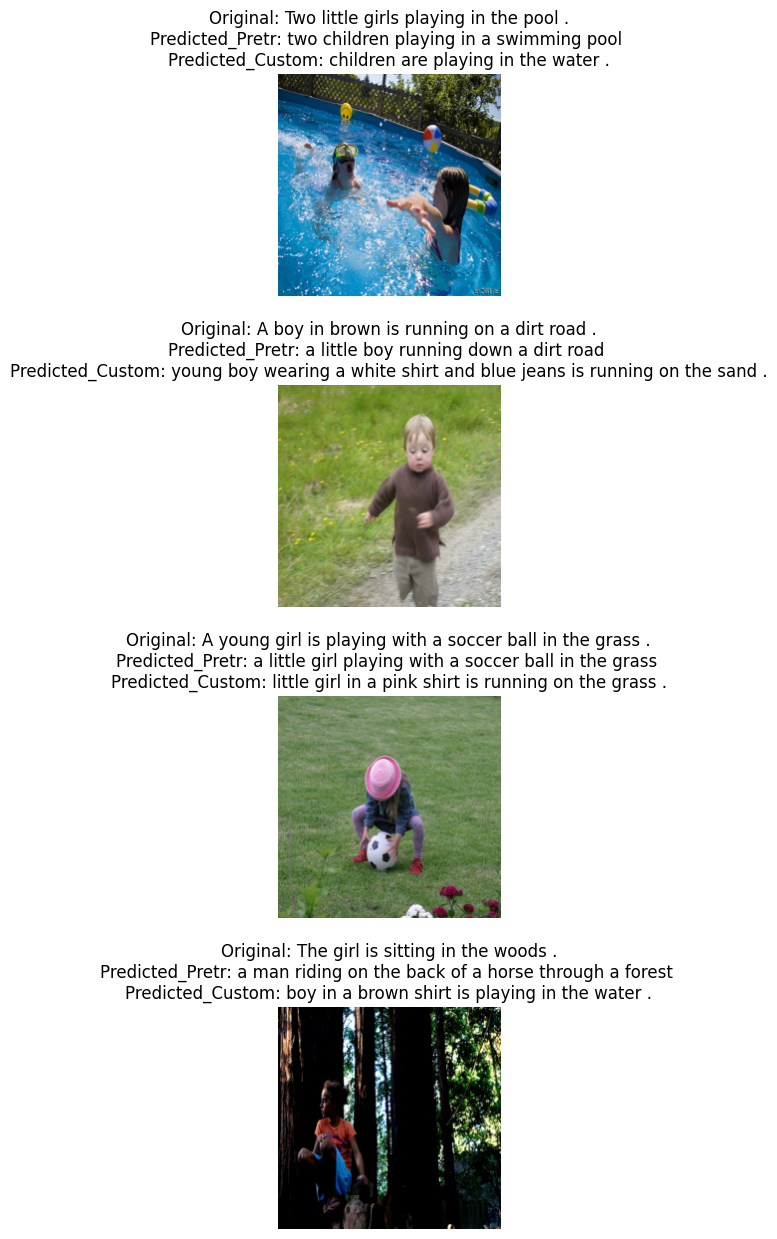

In [32]:
# Define the normalization parameters (mean and std used during normalization)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Function to unnormalize the tensor
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Generate captions for images in the test loader

def get_prediction(model, image):
    model_pretrained.eval()
    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt").to(device)
        # Generate captions
        outputs = model.generate(**inputs, max_length=50, num_beams=5)
        caption = processor.decode(outputs[0], skip_special_tokens=True)
    return caption


dataiter = iter(test_loader)
images,captions,_= next(dataiter)
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(15,15))
index = 0
for  i ,axes  in enumerate(ax.flatten()):

    unnormalized_img = unnormalize(images[i].clone(), mean, std)
    # custome model prediction
    custom_caps,alphas = get_caps_from(unnormalized_img.clone().unsqueeze(0))
    # Ensure the tensor is in the range [0, 1]
    unnormalized_tensor = torch.clamp(unnormalized_img, 0, 1)
    # Convert the tensor to a PIL image
    to_pil = transforms.ToPILImage()
    pil_image = to_pil(unnormalized_tensor.squeeze())
    predicted_caption = get_prediction(model_pretrained, pil_image) 
    predicted_caption_custom= ' '.join(custom_caps[1:-1])
    # predicted_caption = [dataset.index_to_vocab[token] for token in predicted_caption.tolist()]
    original_caption = [dataset.index_to_vocab[token] for token in captions[i].tolist()]
    index_EOS = original_caption.index('<EOS>')
    
    # predicted_caption = ' '.join(predicted_caption[1:-1])
    original_caption = ' '.join(original_caption[1:index_EOS])
    axes.set_title(f"Original: {original_caption}\nPredicted_Pretr: {predicted_caption} \nPredicted_Custom: {predicted_caption_custom}")
    axes.imshow(pil_image)
    axes.axis('off')
# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust these values as needed
plt.show()

In [33]:
# ADD YOUR CODE HERE
from torchtext.data.metrics import bleu_score
def evaluate_model(model, dataloader, vocab, device):
    model.eval()
    references = []
    hypotheses = []

    with torch.no_grad():
        for images, captions,all_captions in test_loader:
            images = images.to(device)
            captions = captions.to(device)
            captions = captions.cpu().detach().numpy()
            # Convert predictions and references to lists of tokens
            for i in range(len(captions)):
                all_caption = all_captions[i]
                unnormalized_img = unnormalize(images[i].clone(), mean, std)
                # Ensure the tensor is in the range [0, 1]
                unnormalized_tensor = torch.clamp(unnormalized_img, 0, 1)
                # Convert the tensor to a PIL image
                to_pil = transforms.ToPILImage()
                pil_image = to_pil(unnormalized_tensor.squeeze())
                predicted = get_prediction(model_pretrained, pil_image)
                references.append(list(map(lambda x: x.split(), all_caption)))
                hypotheses.append(predicted.split())
            

    # Calculate BLEU scores
    bleu1 = bleu_score(hypotheses, references, max_n=1, weights=[1.0])
    bleu2 = bleu_score(hypotheses, references, max_n=2, weights=[0.5, 0.5])
    bleu3 = bleu_score(hypotheses, references, max_n=3, weights=[0.33, 0.33, 0.33])

    return bleu1, bleu2, bleu3
bleu1, bleu2, bleu3 = evaluate_model(model_pretrained, test_loader, dataset, device)

print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")

/tmp/ipykernel_10050/515541939.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  captions = [torch.tensor(caption) for caption in captions]


BLEU-1: 0.6454
BLEU-2: 0.4619
BLEU-3: 0.3299


# 3. COMPARISON
Compare the performance of the two models using **BLEU-1, 2** and **3**. Show some visualizations of predictions from both models. Justify their differences. How would you improve your own custom model?



## BLEU Score Comparison

| **Model**           | **BLEU-1** | **BLEU-2** | **BLEU-3** |
|----------------------|------------|------------|------------|
| **BLIP (Pretrained)** | 0.6376     | 0.4547     | 0.3245     |
| **Custom Model**     | 0.6834     | 0.5042     | 0.3801     |

## BLIP Model Overview
BLIP (Bootstrapped Language-Image Pretraining) is a transformer-based image-captioning model trained on large-scale datasets such as COCO and Conceptual Captions. It uses:
- A Vision Transformer (ViT) for image encoding.
- A GPT-like architecture for caption generation.

BLIP excels at general-purpose image-captioning tasks due to its diverse pretraining.

## Custom Model Overview
The custom model for this task includes:
- **Encoder**: A ResNet backbone for feature extraction.
- **Attention Mechanism**: To provide contextual focus on relevant features.
- **Decoder**: An LSTM for caption generation.

The model was fine-tuned on the Flickr8k dataset and demonstrates better performance due to its adaptation to the dataset's characteristics.

---

## Why BLIP Underperforms
1. **Dataset Mismatch**: BLIP was not specifically fine-tuned for Flickr8k, leading to weaker adaptation to this dataset.
2. **Architectural Suitability**: While BLIP's transformers excel at large-scale datasets, the ResNet-LSTM architecture in the custom model is better suited for Flickr8k.
3. **Generalization vs. Specialization**: BLIP is optimized for diverse datasets, whereas the custom model specializes in Flickr8k.

---

## Improving BLIP Performance
1. **Fine-Tuning**:
   - Train BLIP on Flickr8k with a low learning rate.
   - Use domain-specific augmentations.

2. **Hyperparameter Tuning**:
   - Experiment with batch size, learning rate, and weight decay.
   - Use advanced optimizers like AdamW.

---

## Improving the Custom Model


1. **Enhance Attention**:
   - Replace simple attention with multi-head self-attention.

2. **Integrate Transformer Decoder**:
   - Use a transformer-based decoder instead of LSTM for better sequence modeling.

3. **Regularization**:
   - Use data augmentation to prevent overfitting.


